In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
l=[]
ids=[]
for i in os.listdir('/content/drive/MyDrive/AV/'):
  ids.append(i)
  s1 = i+'--artry.jpg'
  s2=i+'--arteries.jpg'
  s3=i+'--artery.jpg'
  if(s1 in os.listdir('/content/drive/MyDrive/AV/'+i)):
    l.append('/content/drive/MyDrive/AV/'+i+'/'+s1)
  elif (s2 in os.listdir('/content/drive/MyDrive/AV/'+i)):
    l.append('/content/drive/MyDrive/AV/'+i+'/'+s2)
  elif(s3 in os.listdir('/content/drive/MyDrive/AV/'+i)  ):
    l.append('/content/drive/MyDrive/AV/'+i+'/'+s3)

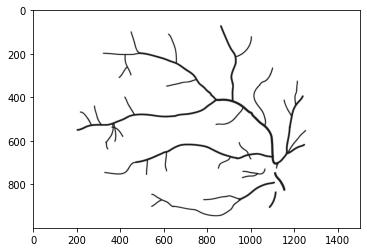

In [ ]:
import matplotlib.pyplot as plt
import cv2
img = plt.imread(l[1])
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')

In [ ]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
masks = []
for label in tqdm(l):
  img = plt.imread(label)
  mask = cv2.resize(img,(256,256),interpolation=cv2.INTER_CUBIC)
  gray = cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
  masks.append(gray)
masks = np.array(masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100 [00:00<?, ?it/s]

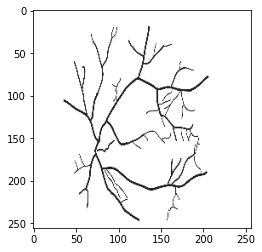

In [ ]:
ind = np.random.randint(98)
plt.imshow(masks[ind],cmap='gray')
# masks = np.array(masks)
# masks.shape

In [ ]:
impath = []
for i in range(len(l)):
  path = l[i]
  path = path.split('/')
  path[-1]=path[-2]+'.JPG'
  path = '/'.join(path)
  impath.append(path)

In [ ]:
images = []
for path in tqdm(impath):
  img = plt.imread(path)
  img = cv2.resize(img,(256,256),interpolation=cv2.INTER_CUBIC)
  images.append(img)
images = np.array(images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

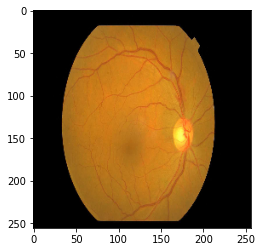

In [ ]:
ind = np.random.randint(98)
plt.imshow(images[ind],cmap='gray')
# masks = np.array(masks)
# masks.shape

In [ ]:
images.shape

(100, 256, 256, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(images,masks,test_size=0.15,random_state=42)

In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor = 'val_loss',
    mode='min',
    patience=5,
    restore_best_weights=True
)

In [ ]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 9.0 MB/s 


In [ ]:
import segmentation_models as sm
preprocess_input = sm.get_preprocessing('vgg16')
rX_train=preprocess_input(X_train)
rX_test = preprocess_input(X_test)
from keras.callbacks import EarlyStopping
sm.set_framework('tf.keras')
resnet =  sm.Unet('vgg16')
callback=EarlyStopping(monitor='val_iou_score',mode='max',patience=50,verbose=1,restore_best_weights=True)
resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[sm.metrics.iou_score])
resnet_history=resnet.fit(x=X_train,y=y_train,epochs=1000,callbacks=[])

Epoch 1/1000
3/3 [==============================] - 4s 663ms/step - loss: 351408.3125 - iou_score: 0.9973
Epoch 2/1000
3/3 [==============================] - 2s 667ms/step - loss: 349062.3125 - iou_score: 1.2105
Epoch 3/1000
3/3 [==============================] - 2s 666ms/step - loss: 348677.6562 - iou_score: 1.3528
Epoch 4/1000
3/3 [==============================] - 2s 673ms/step - loss: 348504.7500 - iou_score: 1.4221
Epoch 5/1000
3/3 [==============================] - 2s 674ms/step - loss: 348445.7500 - iou_score: 1.4688
Epoch 6/1000
3/3 [==============================] - 2s 674ms/step - loss: 348397.1875 - iou_score: 1.5075
Epoch 7/1000
3/3 [==============================] - 2s 681ms/step - loss: 348369.0938 - iou_score: 1.5389
Epoch 8/1000
3/3 [==============================] - 2s 680ms/step - loss: 348346.9375 - iou_score: 1.5645
Epoch 9/1000
3/3 [==============================] - 2s 683ms/step - loss: 348330.0625 - iou_score: 1.5837
Epoch 10/1000
3/3 [===========================

In [ ]:

import pickle as pkl

pkl.dump(resnet,open('./model.pkl','wb'))
# resnet_history=resnet.fit(x=X_train,y=y_train,epochs=500,callbacks=[])


INFO:tensorflow:Assets written to: ram://437c082b-9b24-4155-86da-9f321c0671ea/assets


In [ ]:

def pred(img):
  img = resnet.predict(np.expand_dims(img,axis=0))
  img2 = img[0,:,:,0]
  img2 = img2*255
  im = cv2.threshold(img2, 100, 255, cv2.THRESH_BINARY)[1]
  im = im.astype(int)

  for i in range(256):
    for j in range(256):
      if im[i][j]==0:
        i1[i][j][0]=255
        i1[i][j][1]=0
        i1[i][j][2]=0
  return (im,i1)
# return 

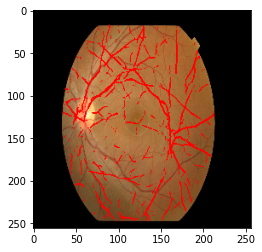

In [ ]:
(mask,im) = pred(X_test[1])
plt.imshow(im)

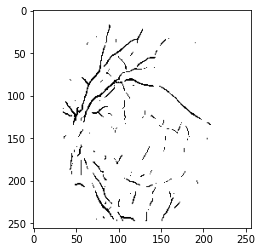

In [ ]:
plt.imshow(mask,cmap='gray')

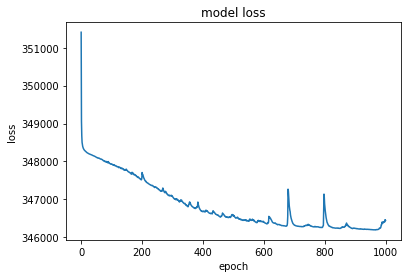

In [ ]:
plt.plot(resnet_history.history['loss'])
# plt.plot(resnet_history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

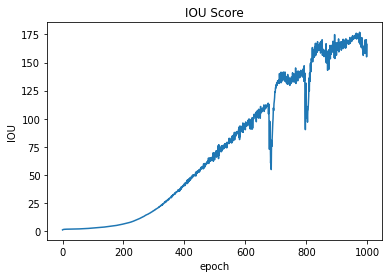

In [ ]:
plt.plot(resnet_history.history['iou_score'])
plt.title('IOU Score')
plt.ylabel('IOU')
plt.xlabel('epoch')
plt.show()